In [4]:
import sys
sys.path.append('../')

In [5]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader

In [6]:
hashs = ["2022-07-02_18-54-27", "2022-07-02_18-53-46", "2022-07-02_17-15-34",
         "2022-07-02_17-15-14", "2022-07-02_11-20-21", "2022-07-02_11-17-38",
         "2022-07-02_09-40-42", "2022-07-02_09-38-52", "2022-07-02_08-00-57", "2022-07-02_08-00-31"]

In [7]:
finetune_dir = '../checkpoints/pet-supmoco/resnet/2022-07-02_08-00-31/finetune/2022-07-03_13-41-32'

In [8]:
config = os.path.join(finetune_dir, 'configs.json')
with open(config, 'rb') as fb:
    config = json.load(fb)
    config = edict(config)

In [9]:
config.server = 'dgx'
config.gpus = ['2']
local_rank = 0
set_gpu(config)

In [10]:
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True

torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
if config.small_kernel:
    backbone._fix_first_conv()
if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(os.path.join(finetune_dir, "ckpt.last.pth.tar"), key='backbone')
classifier.load_weights_from_checkpoint(os.path.join(finetune_dir, "ckpt.last.pth.tar"), key='classifier')

In [11]:
# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  mean_std=mean_std,
                                                  min_max=min_max,
                                                  crop=config.crop,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur=config.blur,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [12]:
from monai.visualize import CAM, GradCAM

In [13]:
class ModelViz(nn.Module):
    def __init__(self, local_rank):
        super(ModelViz, self).__init__()
        self.local_rank = local_rank
    
    def _build_model(self, backbone, classifier):
    
        self.backbone = backbone
        self.classifier = classifier
        
        self.backbone.to(self.local_rank)
        self.classifier.to(self.local_rank)
        self.backbone.eval()
        self.classifier.eval()
    def forward(self, x):
        logits = self.classifier(self.backbone(x))
        return logits

In [14]:
model = ModelViz(local_rank)
model._build_model(backbone, classifier)

In [15]:
gradcam = GradCAM(nn_module=model, target_layers='backbone.layer4')

In [16]:
for batch in train_loader:
    gradcam_result = gradcam(batch['x'].to(local_rank))
    break

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

print(batch['y'])

tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])


In [36]:
idx = 2

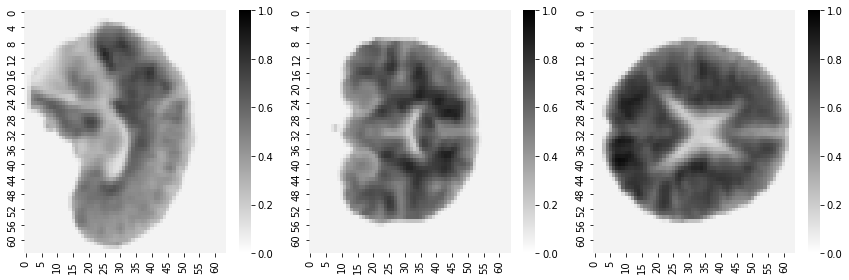

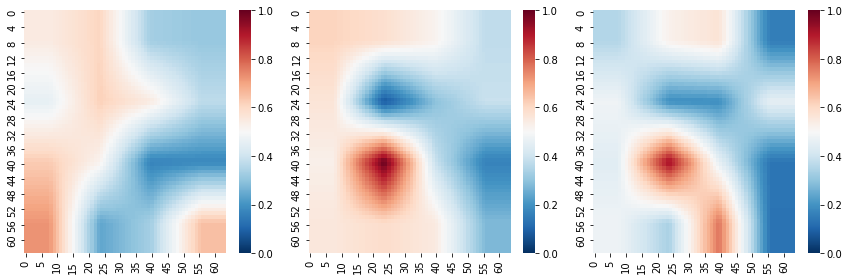

In [37]:
image = batch['x'][idx][0].numpy()
viz_grad = gradcam_result[idx][0].cpu().numpy()

viz_grad = np.abs(viz_grad - 1)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()
sns.heatmap(image[32, :, :], vmin=0, vmax=1, ax=axs[0], cmap='binary')
sns.heatmap(image[:, 32, :], vmin=0, vmax=1, ax=axs[1], cmap='binary')
sns.heatmap(image[:, :, 32], vmin=0, vmax=1, ax=axs[2], cmap='binary')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()
sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=1, cmap='RdBu_r')
sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=1, cmap='RdBu_r')
sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=1, cmap='RdBu_r')
plt.tight_layout()
plt.show()